## Find and Search Hashtags

This notebook carries out the following steps:

1. Find trending topics in each available US city once every *interval* for *reps* *interval*s.  
2. Search for *tweet_samples* examples of the top *hash_samples* hashtags.
3. For each hashtag, clean up the data.  
    -remove retweets, duplicates, users with 0 followers, tweets under *min_words* words, users with tweets that are too similar to one another  
4. For hashtags that still have at least *minimum_tweets*, create a pdf with some examples and a word cloud, for raters to rate on whether the hashtags are cause-related  
5. Repeat the entire process *overall_reps* times

In [1]:
## Set Variables
db_name = '20180411_hashtags_TEST6'
pdf_name = 'hashtags_TEST'
ht_filename = 'hashtag_test' ## to be ... something else
reps = 1 ## to be 12
interval = 30 ## to be 3600
hash_samples = 15 ## to be 200
tweet_samples = 300 ## to be 5000
minimum_tweets = 30 ## to be 500 (fewest tweets allowed per hashtag)
min_words = 5 ## shortest allowed tweet
ownership_dictionary = ['mine','my','your','yours','our','ours','their','theirs'] ##### add their
lev_if = 5 ## number of tweets per user that will trigger a levenshtein check
lev_cutoff = 0.7 ## minimum allowable levenshtein distance
overall_reps = 1 # will be 5

### General setup

In [24]:
import tweepy
import re
import sqlite3
import random
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from itertools import compress
from time import time, sleep
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch, cm
from reportlab.pdfgen import canvas
from reportlab.pdfbase.pdfmetrics import stringWidth
from reportlab.platypus import Image
from math import inf

%matplotlib inline

In [3]:
access_token = 'xxx'
access_token_secret = 'xxx'
consumer_key = 'xxx'
consumer_secret = 'xxx'

In [4]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [5]:
api = tweepy.API(auth)

### Functions for finding hashtags

In [6]:
## TEST WITH US IN, SO WE CAN DECIDE WHAT TO DO
## IF SIMILAR ENOUGH, JUST GO WITH US

def get_woeids():
    avails = api.trends_available() #### !!!
    #is_us = [a['country'] == 'United States' and a['name'] != 'United States' for a in avails]
    is_us = [a['country'] == 'United States' for a in avails]
    us_avails = list(compress(avails, is_us))
    places = [a['name'] for a in us_avails]
    woeids = [a['woeid'] for a in us_avails]
    return(places, woeids)

In [7]:
def find_hashtags(places, woeids, ht_filename, i):
    # start the search
    search = []
    for woeid in woeids:
        city_trends = api.trends_place(woeid)
        queries = [trend['query'] for trend in city_trends[0]['trends']]
        search.append(queries)

    # write results
    search_df = pd.DataFrame(search).T
    search_df.columns = places
    search_df.to_csv(ht_filename + str(i) + '.csv', index = False)

In [8]:
def repeated_finder(places, woeids, ht_filename, reps, interval):
    for i in range(reps):
        start_time = time()
        find_hashtags(places, woeids, ht_filename, i)
        if i < (reps - 1):
            remaining = time() - start_time
            print('sleeping')
            sleep(interval - remaining)

### Functions for scoring and filtering hashtags

In [9]:
def scorer(row):
    return(2 ** (-row/5))

In [10]:
### HERE NEED TO ALSO FILTER OUT OLD HASHTAGS
## BEFORE TAKING THE TOP 200

In [11]:
def score_hashtags(repeats, ht_filename, hash_samples):
    tagdict = {}
    for i in range(reps):
        data = pd.read_csv(ht_filename + str(i) + '.csv')

        for city in data:
            for row,tag in enumerate(data[city]):
                lowered = str(tag).lower()
                if lowered not in tagdict:
                    tagdict[lowered] = scorer(row)
                else:
                    tagdict[lowered] += scorer(row)
                    
    keys = []
    values = []
    for key,value in tagdict.items():
        keys.append(key)
        values.append(value)
    
    tag_df = pd.DataFrame({'hashtag':keys,'score':values})
    tag_df = tag_df[tag_df.hashtag != 'nan']
    tag_df = tag_df.sort_values(by = 'score', ascending = False)
    tag_filter = [True if re.search('%23',q) else False for q in tag_df['hashtag']]
    tag_df = tag_df[tag_filter].reset_index(drop = True)
    return(list(tag_df['hashtag'][:hash_samples]))

### Functions for searching tweets

In [12]:
def create_db(db_name, query):
    # create and connect to database
    sqlite_file = db_name + '.sqlite'
    conn = sqlite3.connect(sqlite_file)
    c = conn.cursor()

    # create table
    c.execute('CREATE TABLE {qry}(\
    tweet_id INTEGER PRIMARY KEY,\
    datetime TEXT,\
    source TEXT,\
    user_id TEXT,\
    user_name TEXT,\
    user_location TEXT,\
    user_description TEXT,\
    user_followers TEXT,\
    user_friends TEXT,\
    user_acc_age TEXT,\
    user_verified TEXT,\
    user_statuses TEXT,\
    user_offset TEXT,\
    user_lang TEXT,\
    is_quote_status TEXT,\
    favorited TEXT,\
    retweeted TEXT,\
    language TEXT,\
    mentions TEXT,\
    reply_to TEXT,\
    is_retweet TEXT,\
    retweet_text TEXT,\
    retweet_user TEXT,\
    text TEXT)'\
        .format(qry='hashtag_'+query))
    
    conn.commit()
    
    return(c,conn)

In [13]:
def create_cursor(queries,max_tweets):
    cursor = tweepy.Cursor(api.search,
                           count=100,
                           q=queries,
                           tweet_mode='extended').items(max_tweets)
    return(cursor)

In [14]:
def pull_tweets(query,cursor,c,conn,api,fullTime):
    tweetCount = 0
    tweet_set = []

    for fulltweet in cursor:
        tweetCount += 1
        tweet = fulltweet._json
    
        tweet_id = tweet['id_str']
        datetime = tweet['created_at']
        source = tweet['source']
        user_id = tweet['user']['id_str']
        user_name = tweet['user']['screen_name']
        user_location = tweet['user']['location']
        user_description = tweet['user']['description']
        user_followers = tweet['user']['followers_count']
        user_friends = tweet['user']['friends_count']
        user_acc_age = tweet['user']['created_at']
        user_verified = tweet['user']['verified']
        user_statuses = tweet['user']['statuses_count']
        user_offset = tweet['user']['utc_offset']
        user_lang = tweet['user']['lang']
        is_quote_status = tweet['is_quote_status']
        favorited = tweet['favorited']
        retweeted = tweet['retweeted']
        language = tweet['lang']
        if 'user_mentions' in tweet['entities']['user_mentions']:
            mentions = tweet['entities']['user_mentions']['id_str']
        else:
            mentions = None
    
        if 'in_reply_to_user_id_str' in tweet:
            reply_to = tweet['in_reply_to_user_id_str']
        else:
            reply_to = None
    
        if 'retweeted_status' in tweet:
            is_retweet = 'yes'
            retweet_text = tweet['retweeted_status']['full_text']
            retweet_user = tweet['retweeted_status']['user']['id_str']
        else:
            is_retweet = 'no'
            retweet_text = None
            retweet_user = None

        if 'text' in tweet:
            text = tweet['text']
       
        if 'full_text' in tweet:
            text = tweet['full_text']
    
        ## put it all together
        tweet_set.append((tweet_id, datetime, source, user_id, user_name,
                user_location,user_location,user_description,
                user_followers,user_friends,user_acc_age,
                user_verified,user_statuses,user_offset,
                user_lang,is_quote_status,favorited,
                retweeted,language,is_retweet,
                mentions,reply_to,retweet_text,
                retweet_user,text))

        if tweetCount % 100 == 0:
            rls = api.rate_limit_status()
            limits_left = rls['resources']['application']['/application/rate_limit_status']['remaining']
            searches_left = rls['resources']['search']['/search/tweets']['remaining']
    
            if limits_left < 3 or searches_left < 3:
            
                c.executemany('INSERT OR IGNORE INTO {qry}\
                (tweet_id, datetime, source, user_id, user_name,\
                user_location,user_location,user_description,\
                user_followers,user_friends,user_acc_age,\
                user_verified,user_statuses,user_offset,\
                user_lang,is_quote_status,favorited,\
                retweeted,language,is_retweet,\
                mentions,reply_to,retweet_text,\
                retweet_user,text)\
                VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,\
                ?,?,?,?,?,?,?,?,?,?,?)'.format(qry='hashtag_'+query),
                              tweet_set)
                conn.commit()
            
                tweet_set = []
            
                snooze = max([30 + 15 * 60 - (time() - fullTime),0]) ### want to inherite time from last search
                print('Snoozing for ',snooze,', with ',tweetCount,' completed so far.')
                sleep(snooze)
                fullTime = time()
                print('back to searching')

    # at the end of the cursor
    if len(tweet_set) > 0:
        c.executemany('INSERT OR IGNORE INTO {qry}\
        (tweet_id, datetime, source, user_id, user_name,\
        user_location,user_location,user_description,\
        user_followers,user_friends,user_acc_age,\
        user_verified,user_statuses,user_offset,\
        user_lang,is_quote_status,favorited,\
        retweeted,language,is_retweet,\
        mentions,reply_to,retweet_text,\
        retweet_user,text)\
        VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,\
        ?,?,?,?,?,?,?,?,?,?,?)'.format(qry='hashtag_'+query),
                      tweet_set)
        conn.commit()
    
    conn.close()
    print('done!')
    return(time())

In [15]:
def search(queries,db_name,tweet_samples):
    current_time = time()
    for i,q in enumerate(queries):
        print('searching for...' + q)
        c,conn = create_db(db_name, q[3:])
        cursor = create_cursor(q,tweet_samples)
        current_time = pull_tweets(q[3:],cursor,c,conn,api,current_time)

### Functions for cleaning data

In [16]:
def query_table(c,query):
    c.execute('SELECT * FROM {tn} WHERE {cn}="no"'.\
        format(coi='id', tn=query, cn='is_retweet'))

    check = c.fetchall()
    df = pd.DataFrame(check)
    df.columns = ['tweet_id', 'datetime', 'source', 'user_id',
                  'user_name','user_location',
                  'user_description','user_followers',
                  'user_friends','user_acc_age',
                  'user_verified','user_statuses','user_offset',
                  'user_lang','is_quote_status','favorited',
                  'retweeted','language','is_retweet',
                  'mentions','reply_to','retweet_text',
                  'retweet_user','text']

    return(df)

def trim_data(df,items):
    df = df[df['language'] == 'en']
    df = df[df['user_followers'] != '0']
    df = df.filter(items=items)
    return(df)

def clean_text(text):
    clean_tweets = []
    for tweet in text:
        clean = tweet.lower() # set to lowercase
        clean = re.sub('\n',' ',clean) # change newline to space
        clean = re.sub('&amp','&',clean) # fix ampersands
        clean = re.sub('#[^ ]*','',clean) # remove hashtags
        clean = re.sub('@[^ ]*','',clean) # remove mentions
        clean = re.sub('http[^ ]*','',clean) # remove links
        clean = re.sub('[^a-z0-9 ]','',clean) # remove non-alphanumerics
        clean = re.sub(' + ',' ',clean) # multi-spaces down to single spaces
        clean = clean.strip()
        clean_tweets.append(clean)
    return(clean_tweets)

def find_duplicates(text):
    cnt = Counter()
    duplicates = [False] * len(text)
    for i,tweet in enumerate(text):
        cnt[tweet] += 1
        if cnt[tweet] > 1:
            duplicates[i] = True
    return(duplicates)

def find_short(text, min_len):
    length = [len(tweet.split(' ')) for tweet in text]
    too_short = [ln < min_len for ln in length]
    return(too_short)

def word_counter(df, text_col, terms):
    df['length'] = [len(tweet.split(' ')) for tweet in df[text_col]]
    for term in terms:
        df[term] = [len(re.findall('\\b'+term+'\\b', tweet)) for tweet in df[text_col]]
    return(df)

def levenshtein(seq1, seq2):
    # from: http://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    #print (matrix)
    return (matrix[size_x - 1, size_y - 1])

def count_tweets(df, user_col):
    ## count number of tweets by each user
    cnt = Counter()
    for tweet in df[user_col]: ## change df_1 to count_df
        cnt[tweet] += 1

    keys = []
    values = []
    for key,value in cnt.items():
        keys.append(key)
        values.append(value)
    
    user_df = pd.DataFrame({'user':keys,'count':values})
    user_df = user_df.sort_values(by = 'count', ascending = False).reset_index(drop = True)
    return(user_df)

def avg_levens(user, df, user_col, text_col):
    levens = []
    user_tweets = list(df[df[user_col] == user][text_col])
    for j in range(2 * len(user_tweets)):
        samp = random.sample(user_tweets,2)
        levens.append(levenshtein(samp[0],samp[1]) / np.mean([len(samp[0]),len(samp[1])]))
    return(np.mean(levens))

def cutoff_levs(user_df, clean_df, user_col, text_col, count_cutoff, lev_cutoff):
    
    all_levs = [inf] * user_df.shape[0]
    for i in range(np.sum(user_df['count'] >= count_cutoff)):
        lev = avg_levens(user_df['user'][i],clean_df,user_col,text_col)
        all_levs[i] = lev
            
    user_df['lev'] = all_levs
    remove_users = list(user_df[user_df['lev'] < lev_cutoff]['user'])
    clean_df = clean_df[-clean_df.user_id.isin(remove_users)]
    return(clean_df)

In [17]:
def tweet_cleanser(db_name):
    
    # connect to the database
    sqlite_file = db_name + '.sqlite'
    conn = sqlite3.connect(sqlite_file)
    c = conn.cursor()

    # get list of hashtags
    tables = []
    res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    for name in res:
        tables.append(name[0])
    
    all_counts = []
    for table in tables:
        # query data
        df = query_table(c,table)

        # add cleaner columns
        df = trim_data(df,['tweet_id', 'user_id','user_followers','text'])
        df['clean_text'] = clean_text(df['text'])
        df['duplicate'] = find_duplicates(df['clean_text'])
        df['short'] = find_short(df['clean_text'], min_words)

        # trim data
        clean_df = df[~df['duplicate'] & ~df['short']].drop(['duplicate','short'], axis = 1)
        
        user_df = count_tweets(clean_df, 'user_id')
        clean_df = cutoff_levs(user_df, clean_df, 'user_id', 'clean_text', lev_if, lev_cutoff)

        all_counts.append(clean_df)
        
    return(all_counts)

### Functions for creating hashtag summary for raters

In [26]:
def create_wordcloud(text,i,stopwords):
    wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=200,
                      max_font_size=40,
                      random_state=42
                     ).generate(str(text))
    fig = plt.figure(figsize=(0.5,0.25))
    plt.imshow(wordcloud)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.axis('off')
    fig.savefig('saved_cloud'+str(i)+'.png', dpi=900)

In [33]:
def split_line(text, tweet_font, tweet_size, max_width):
    new_text = str()
    new_possibles = []
    widths = []
    for word in text.split(' '):
        new_text += ' ' + word
        new_text = new_text.strip()
        new_possibles.append(new_text)
        width = stringWidth(new_text, tweet_font, tweet_size)
        widths.append(width)
    checks = [wid < max_width for wid in widths]
    if False in checks:
        ind = checks.index(False)-1
    else:
        ind = len(widths)-1
    line = new_possibles[ind]
    rest = ' '.join(text.split(' ')[(ind+1):])
    return(line,rest)

def line_splitter(text, max_width, tweet_font, tweet_size):
    num_lines = 1
    line1 = text
    lines = [line1]
    tw = stringWidth(line1, tweet_font, tweet_size)
    if tw > max_width:
        num_lines += 1
        line1, rest = split_line(line1, tweet_font, tweet_size, max_width)
        lines = [line1,rest]
        tw = stringWidth(rest, tweet_font, tweet_size)
        if tw > max_width:
            num_lines += 1
            line2, line3 = split_line(rest, tweet_font, tweet_size, max_width)
            lines = [line1,line2,line3]
            tw = stringWidth(line3, tweet_font, tweet_size)
            if tw > max_width:
                num_lines = 0
    if num_lines > 0:
        return(lines)
    else:
        return(None)

In [34]:
def create_pdf(tweet_data, pdf_name, minimum_tweets, queries):
    cnvs = canvas.Canvas(pdf_name + ".pdf", pagesize=letter)

    stopwords = set(list(STOPWORDS) + ownership_dictionary)
    re_owner = '(\\b'+'\\b)|(\\b'.join(ownership_dictionary)+'\\b)'

    # only look at hashtags that have enough tweets
    counts = []
    for hashtag in tweet_data:
        counts.append(hashtag.shape[0])

    enough = [count > minimum_tweets for count in counts]
    good_hashtags = list(compress(queries, enough))
    good_data = list(compress(tweet_data, enough))

    ## settings for pdf writing
    #from reportlab.lib.units import inch, cm
    w, h = letter
    tweet_font = 'Helvetica'
    tweet_size = 16

    for i in range(len(good_hashtags)):
   
        ## create word cloud
        ## based on https://www.kaggle.com/adiljadoon/word-cloud-with-python
        create_wordcloud(good_data[i]['clean_text'],i,stopwords)

        tweet_samples = random.sample(list(good_data[i]['text']),minimum_tweets)
        clean_samples = []
        for sample in tweet_samples:
            sample = re.sub('\n','',sample)
            sample = re.sub('http[^ ]*','',sample)
            sample = re.sub('"',"'",sample)
            sample = re.sub('&amp;','&',sample)
            sample = re.sub("[^0-9a-zA-Z \.#,';:<>/\?~`!@$%^&\*()-+=]",'',sample)
            sample = sample.strip()
            clean_samples.append(sample)
        
        clean_samples = [sample for sample in clean_samples if not re.search(re_owner,sample.lower())]

        ## create the pdf page
        hashtag = re.sub('%23','#',good_hashtags[i])
    
        cnvs.setLineWidth(.3)
        cnvs.setFont(tweet_font, 24)
 
        ## write out the hashtag
        ht_w = stringWidth(hashtag, tweet_font, 24)
        cnvs.line(inch,h-inch,w-inch,h-inch)
        cnvs.drawString(w/2-ht_w/2, h-inch+10, hashtag)

        cnvs.setFont(tweet_font, tweet_size)
        ## write out a tweet
        max_width = w - inch/2
        pos = 20
        for sample in clean_samples:
            if pos > 390:
                break
            lines = line_splitter(sample, max_width, tweet_font, tweet_size)
            if lines != None:
                for line in lines:
                    t_w = stringWidth(line, tweet_font, tweet_size)
                    cnvs.drawString((w-t_w)/2, h-inch-pos, line)
                    pos += 16
                pos += 20
    
        cnvs.drawImage(x=0.05*w,y=(h - pos - 0.35*h)/4,image='saved_cloud'+str(i)+'.png',
                         width = 0.9*w, height = 0.35*h)
        cnvs.showPage()
    cnvs.save()

    for i in range(len(good_hashtags)):
        os.remove('saved_cloud'+str(i)+'.png')

### Actually run everything

In [ ]:
###  repeat the code 5 times...

In [21]:
## just once at very beginning
places, woeids = get_woeids()

In [22]:
## this starts at 10am and goes to 10pm
repeated_finder(places, woeids, ht_filename, reps, interval)

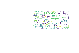

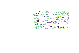

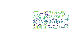

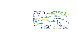

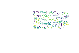

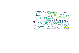

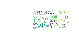

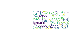

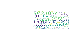

In [35]:
## this starts at 10pm, and goes however long it goes
queries = score_hashtags(reps, ht_filename, hash_samples)
search(queries,db_name,tweet_samples)
all_counts = tweet_cleanser(db_name)
create_pdf(all_counts, pdf_name, minimum_tweets, queries)